# Sampling

we sample from chemical graphs.

First we will fit a sampler and then we will generate new graphs :)


## initialising logging and notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
!date

Thu Feb 18 20:44:20 CET 2016


## fit sampler i.e. fit estimator and grammar

In [2]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

dataset_fname = 'toolsdata/bursi.pos.gspan'

In [3]:
%%time
'''
TRAINING A SAMPLER
'''
from graphlearn.graphlearn import  Sampler
from eden.graph import Vectorizer

# get training graphs
training_graphs = get_graphs(dataset_fname, size=300)

# train a sampler
sampler=Sampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,
                          vectorizer=Vectorizer(3))
sampler.fit(training_graphs)

# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))
sampler.save('tmp/sampler.ge')

graph grammar stats:
#instances: 300   #interfaces: 122   #cores: 54   #core-interface-pairs: 378
CPU times: user 8.58 s, sys: 631 ms, total: 9.22 s
Wall time: 12.6 s


# Sample and show generated graphs

In [4]:
%%time
from itertools import islice

"""
USING A SAMPLER
"""
# reloading, this is not necessary actually since we sould still have the object in memory 
from graphlearn.graphlearn import  Sampler
sampler=Sampler()
sampler.load('tmp/sampler.ge')


# get a graph list and pic some graphs to initialize the sampler with.
# the sampler will look at each graphs and try n_steps times to alter it.
graphs = get_graphs(dataset_fname, size=100)
id_start=34
id_end=id_start+12
input_graphs = islice(graphs,id_start,id_end)

# sample parameters
n_steps=60 # how many steps
n_samples=4 # collect this many samples during the process


# sampler will return lists of graphs as you see below.
graphs = sampler.sample(input_graphs,
                        n_steps=n_steps, n_samples=n_samples,
                        target_orig_cip=False,
                        probabilistic_core_choice=False,
                        score_core_choice= True,
                        max_size_diff=1,
                        burnin=10,
                        include_seed=True,
                        proposal_probability = False,
                        improving_threshold=.5, 
                        improving_linear_start=0.0,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True,  
                        monitor=True)



CPU times: user 347 ms, sys: 23.4 ms, total: 371 ms
Wall time: 370 ms


Graph id: 34


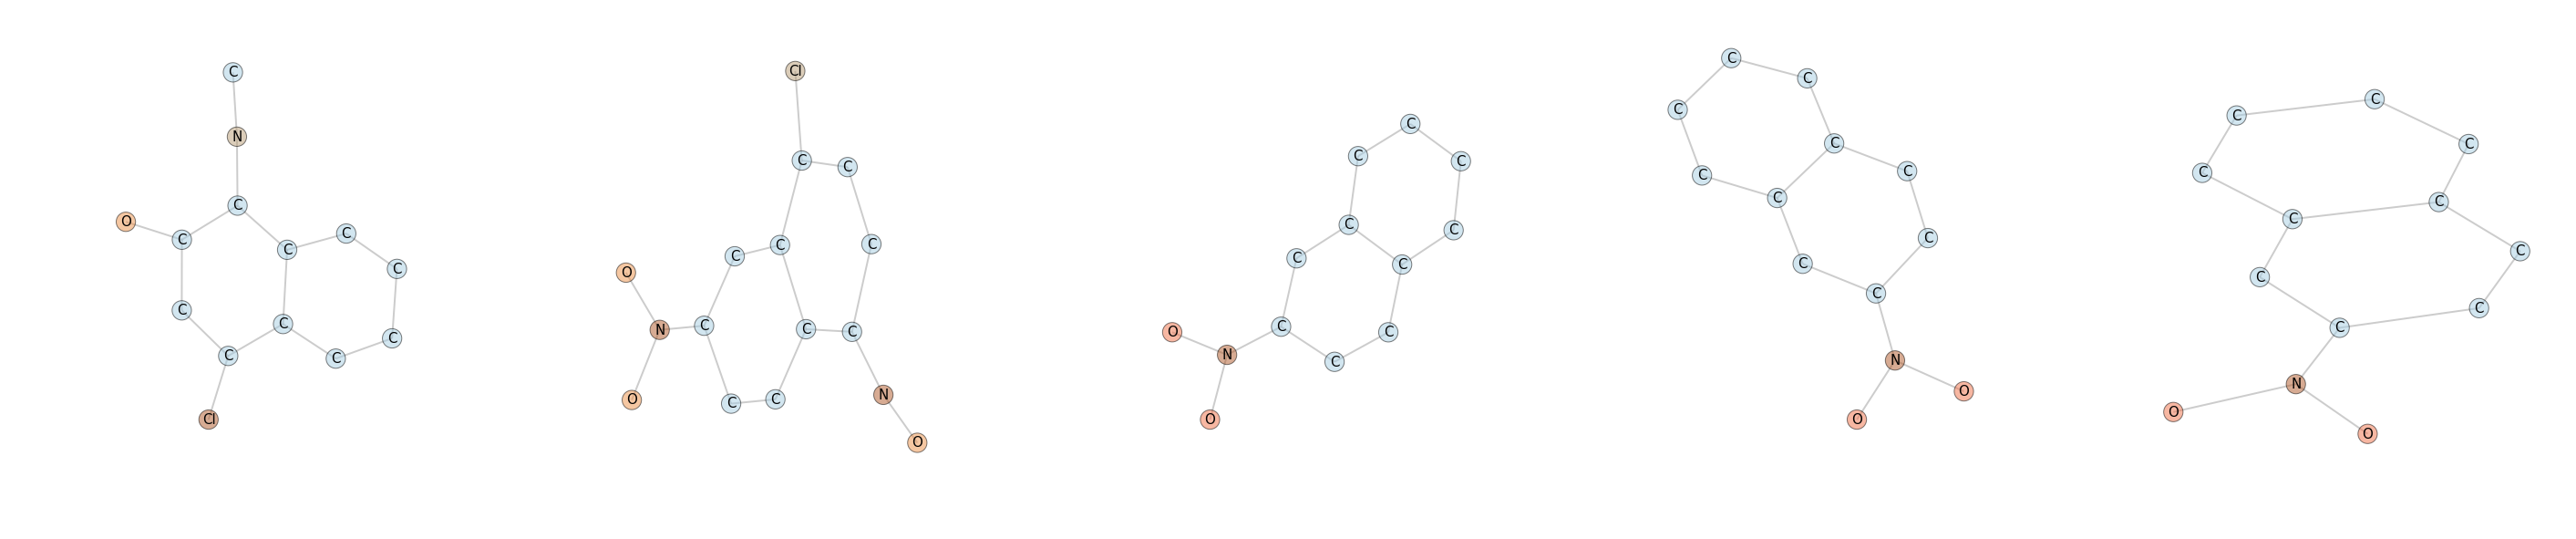

Graph id: 35


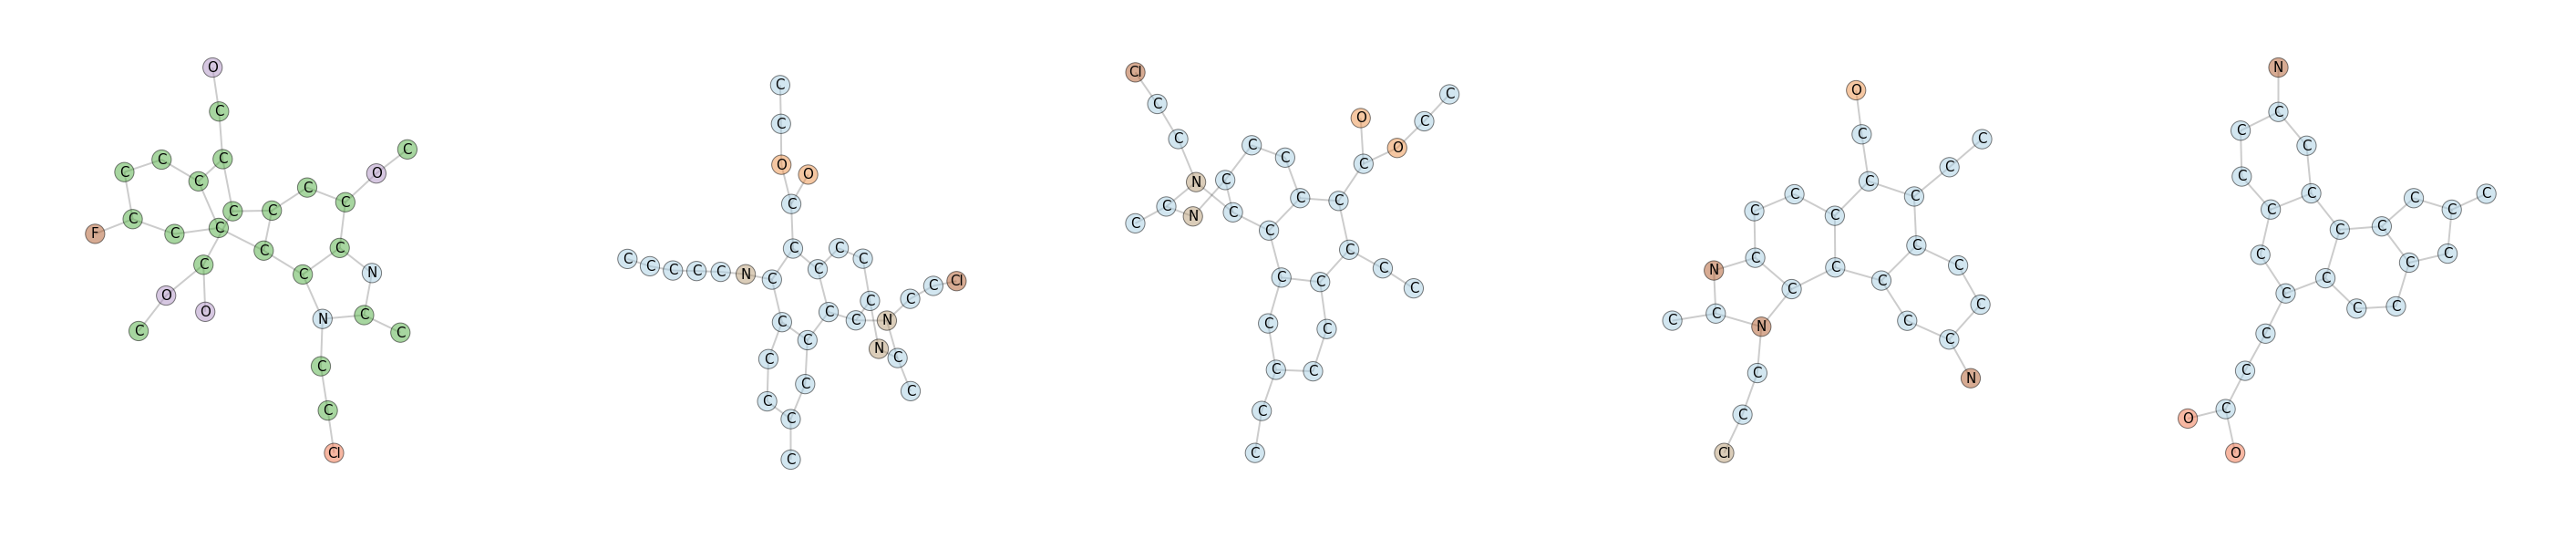

Graph id: 36


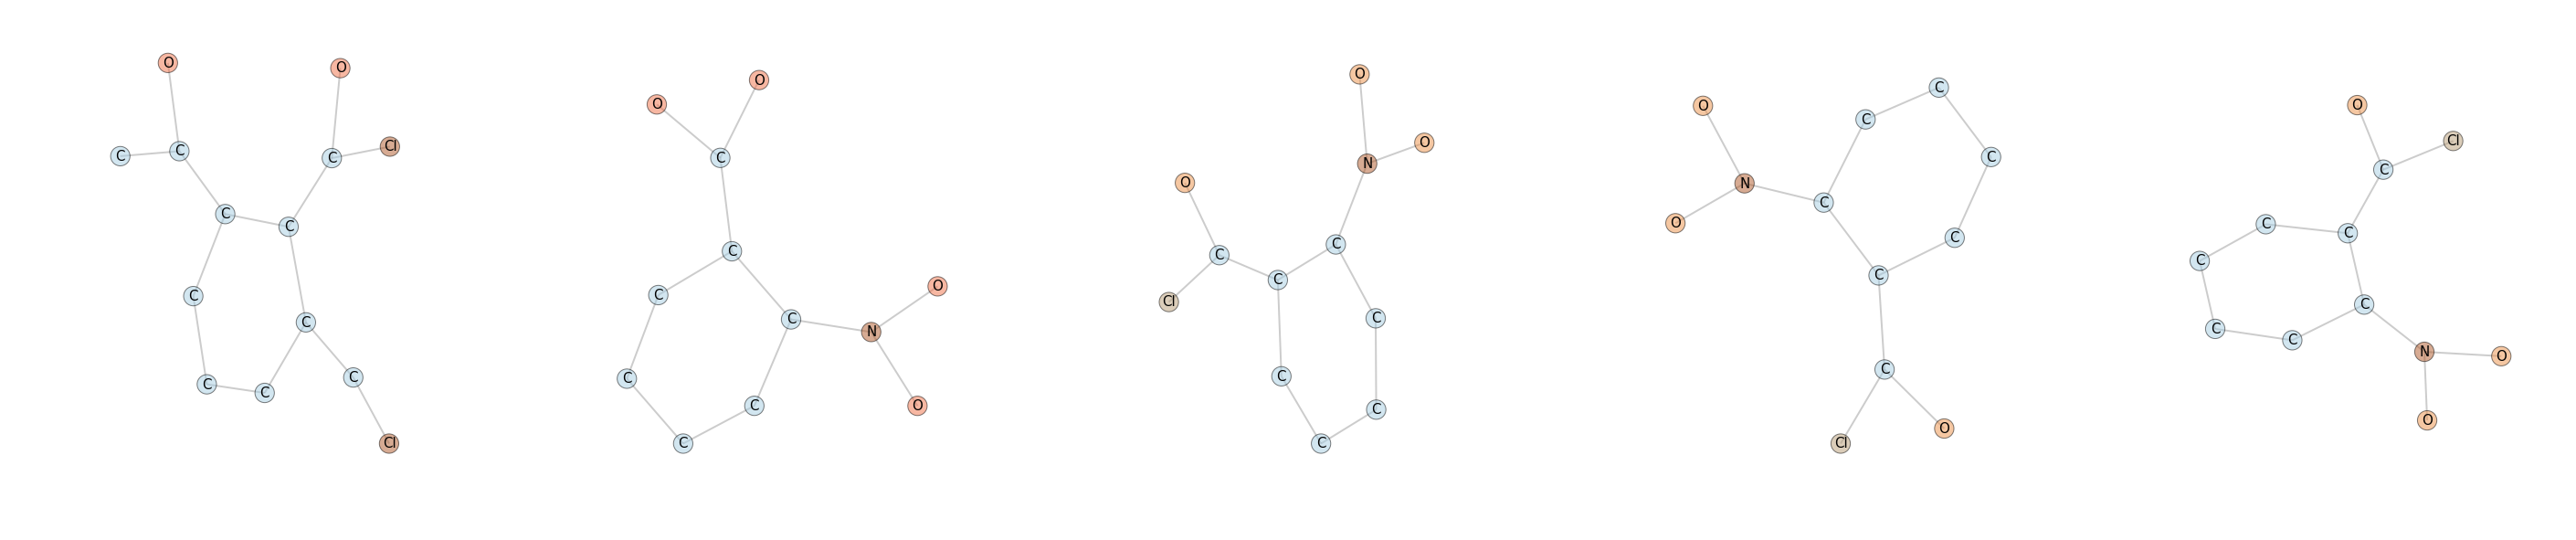

Graph id: 37


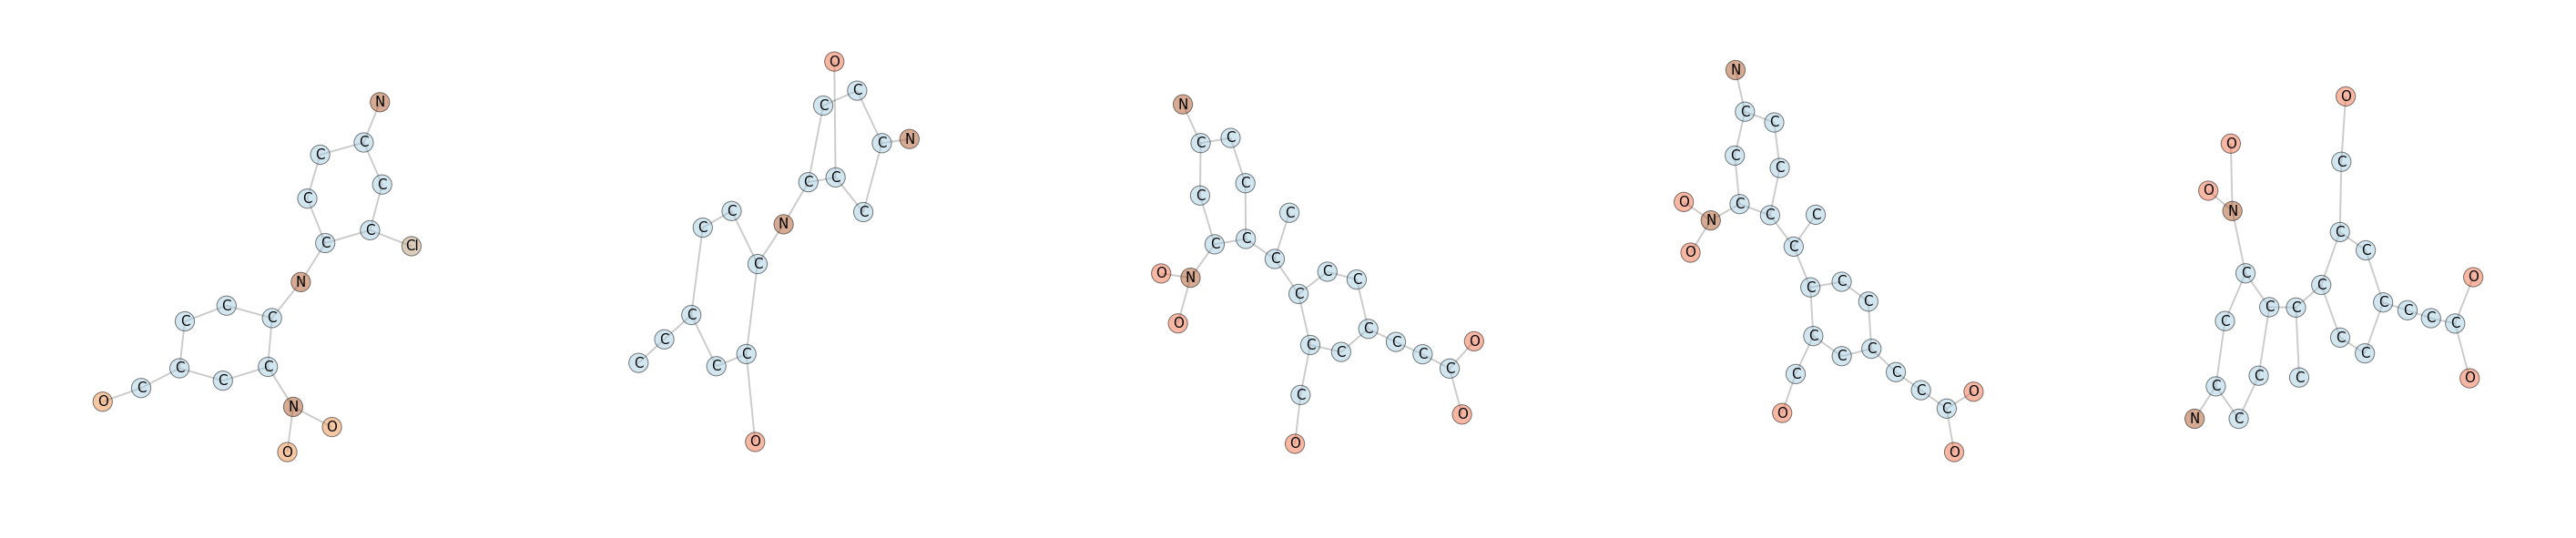

Graph id: 38


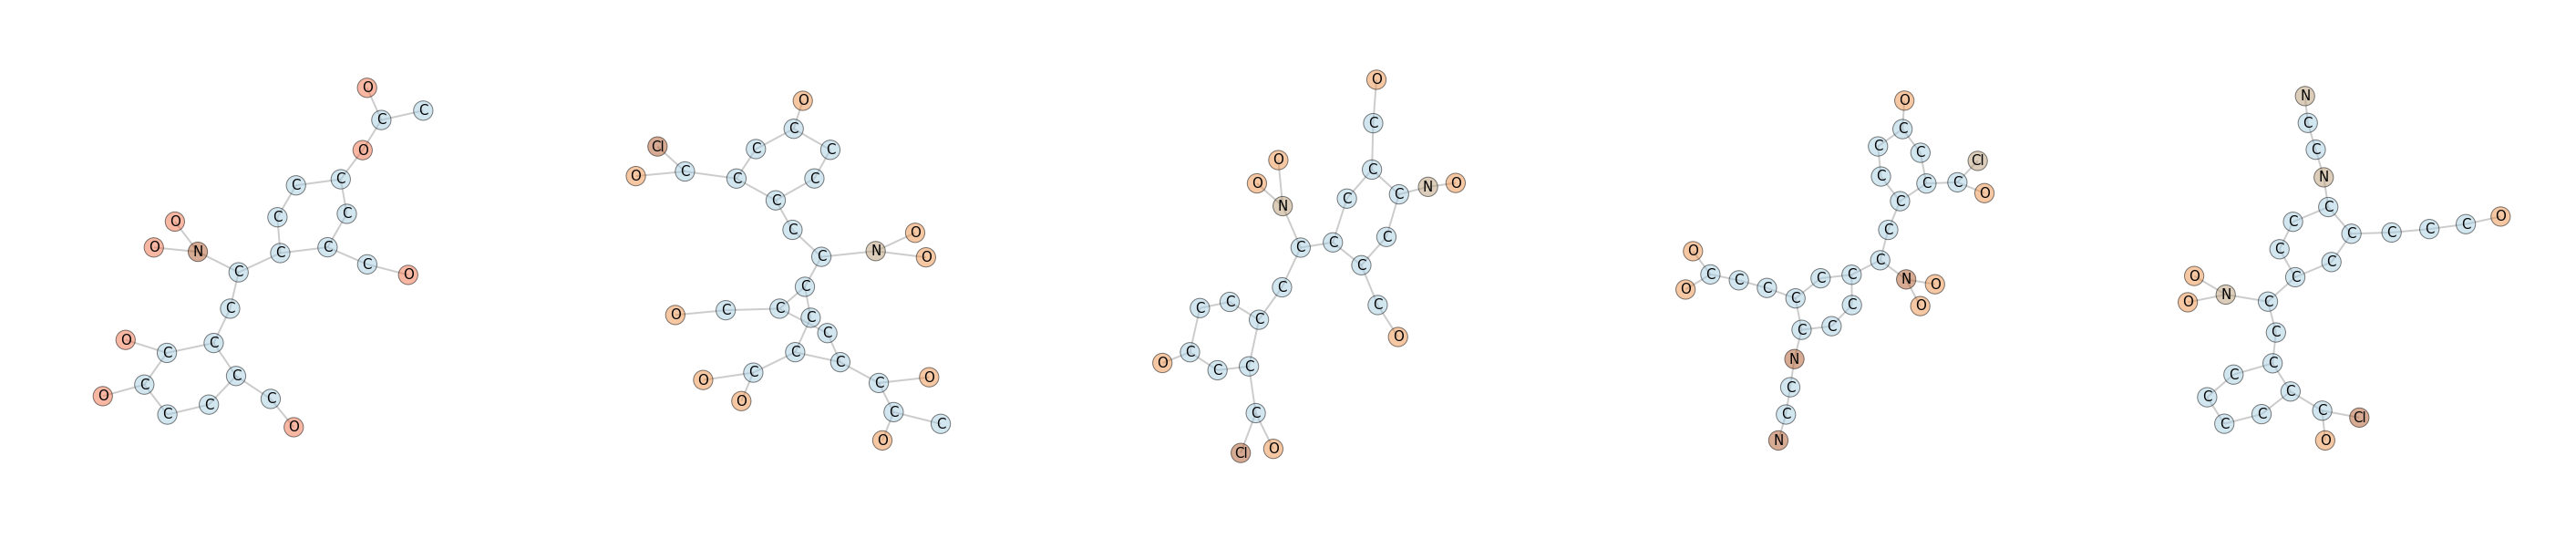

Graph id: 39


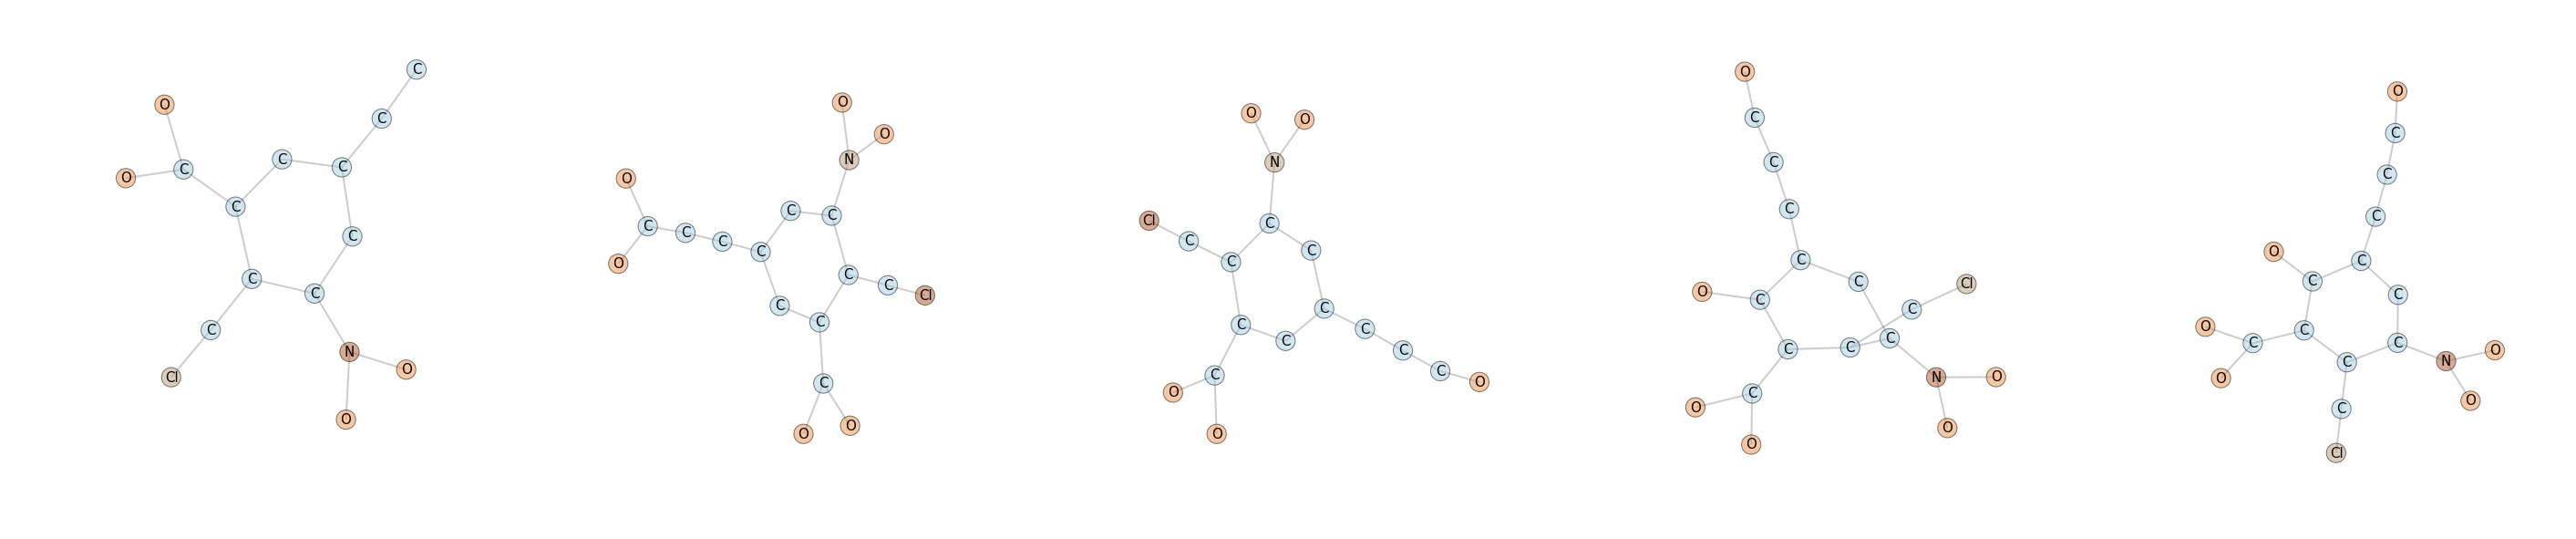

Graph id: 40


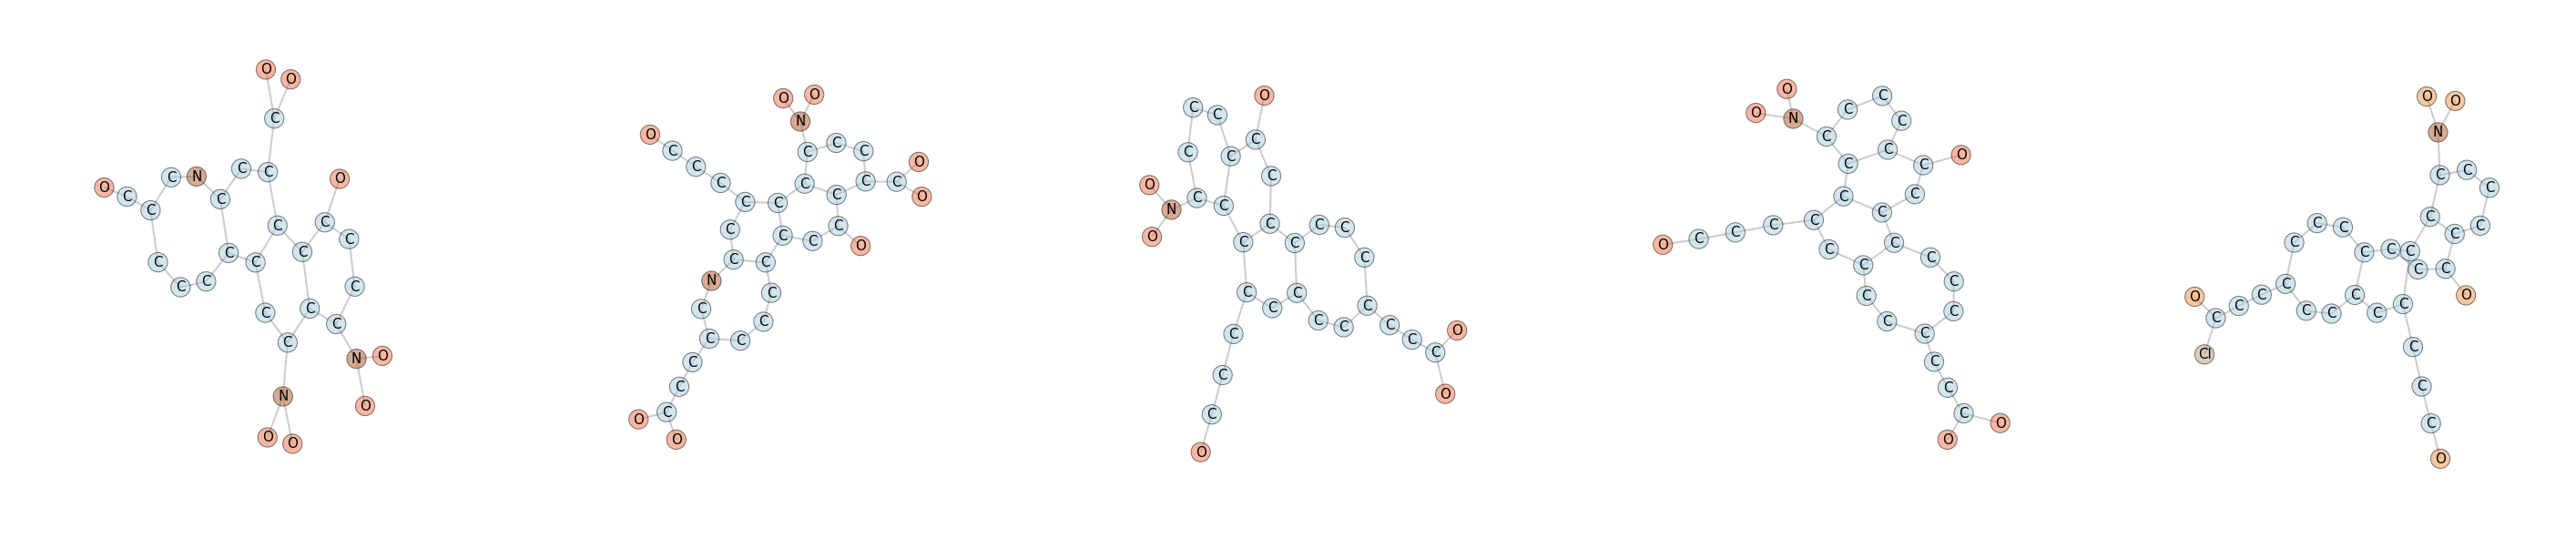

Graph id: 41


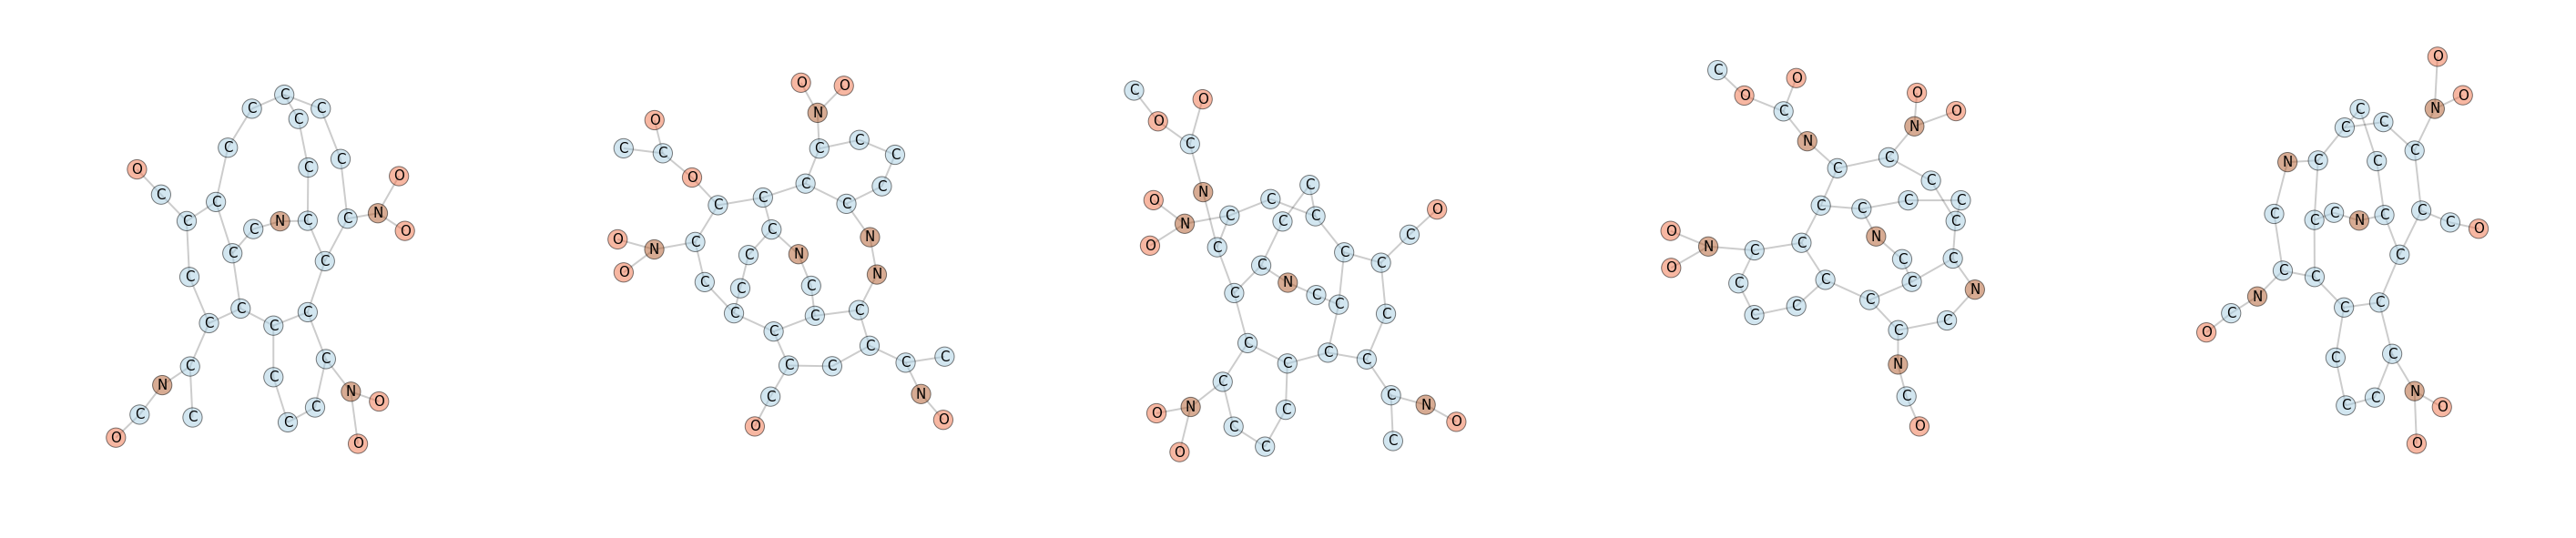

Graph id: 42


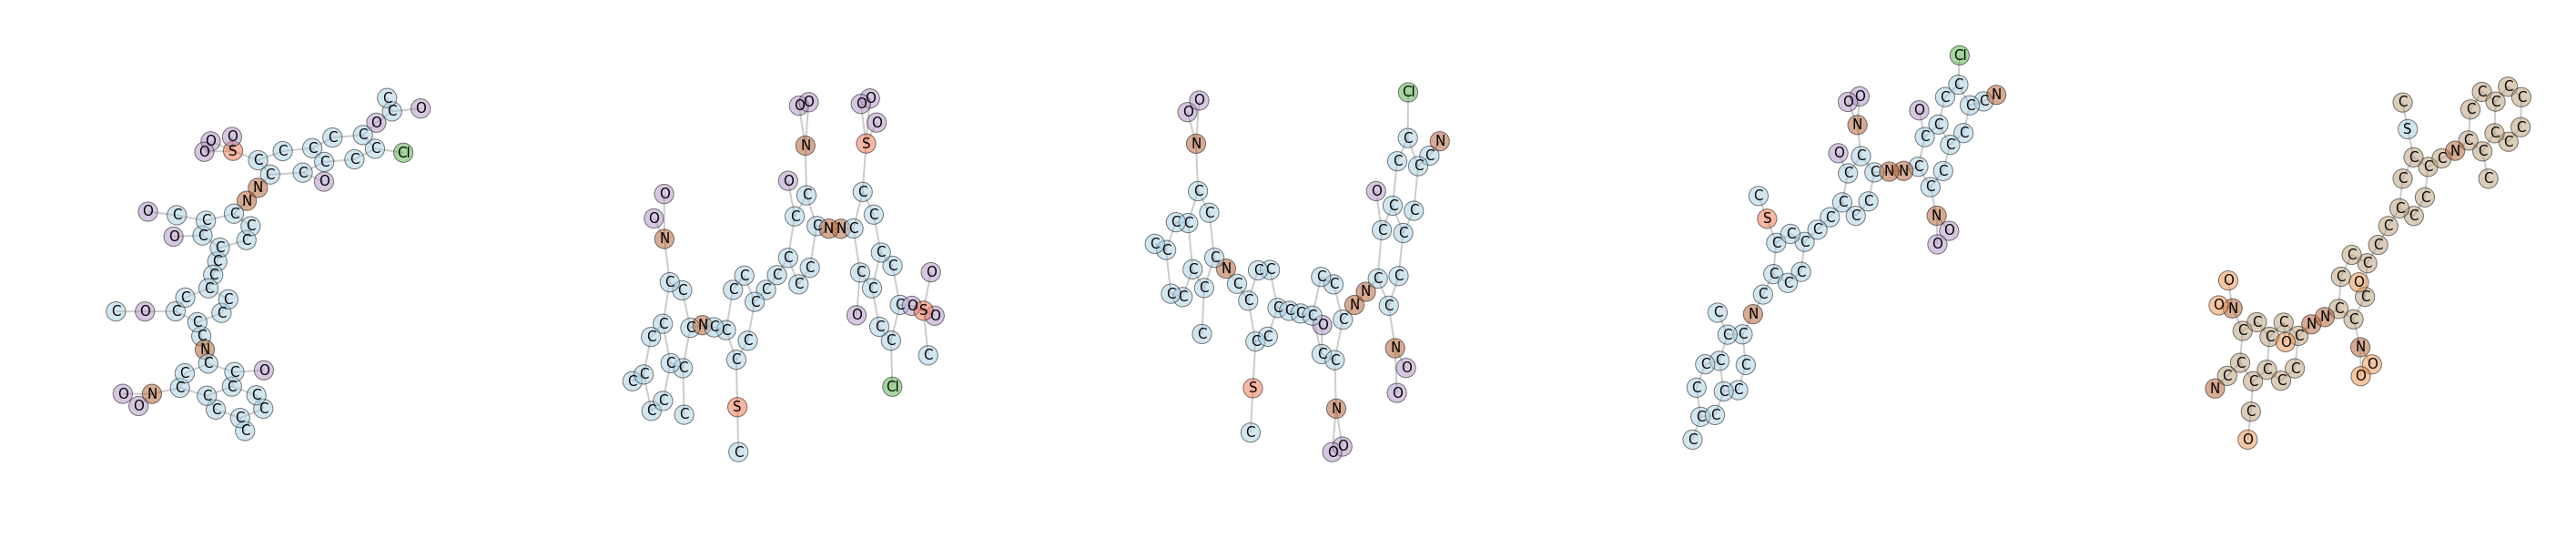

Graph id: 43


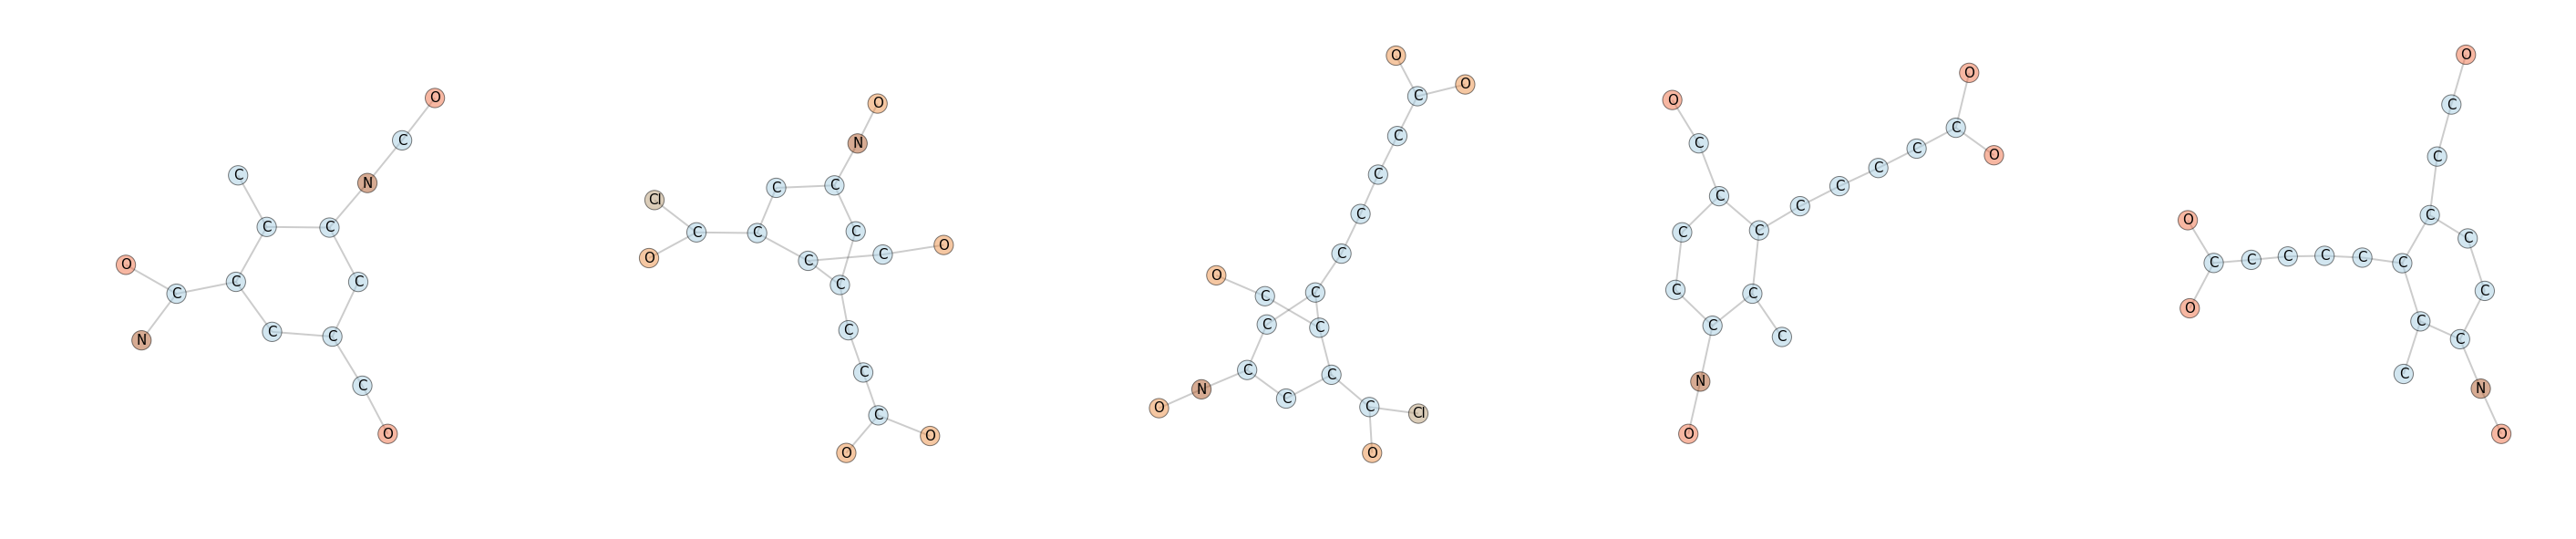

Graph id: 44


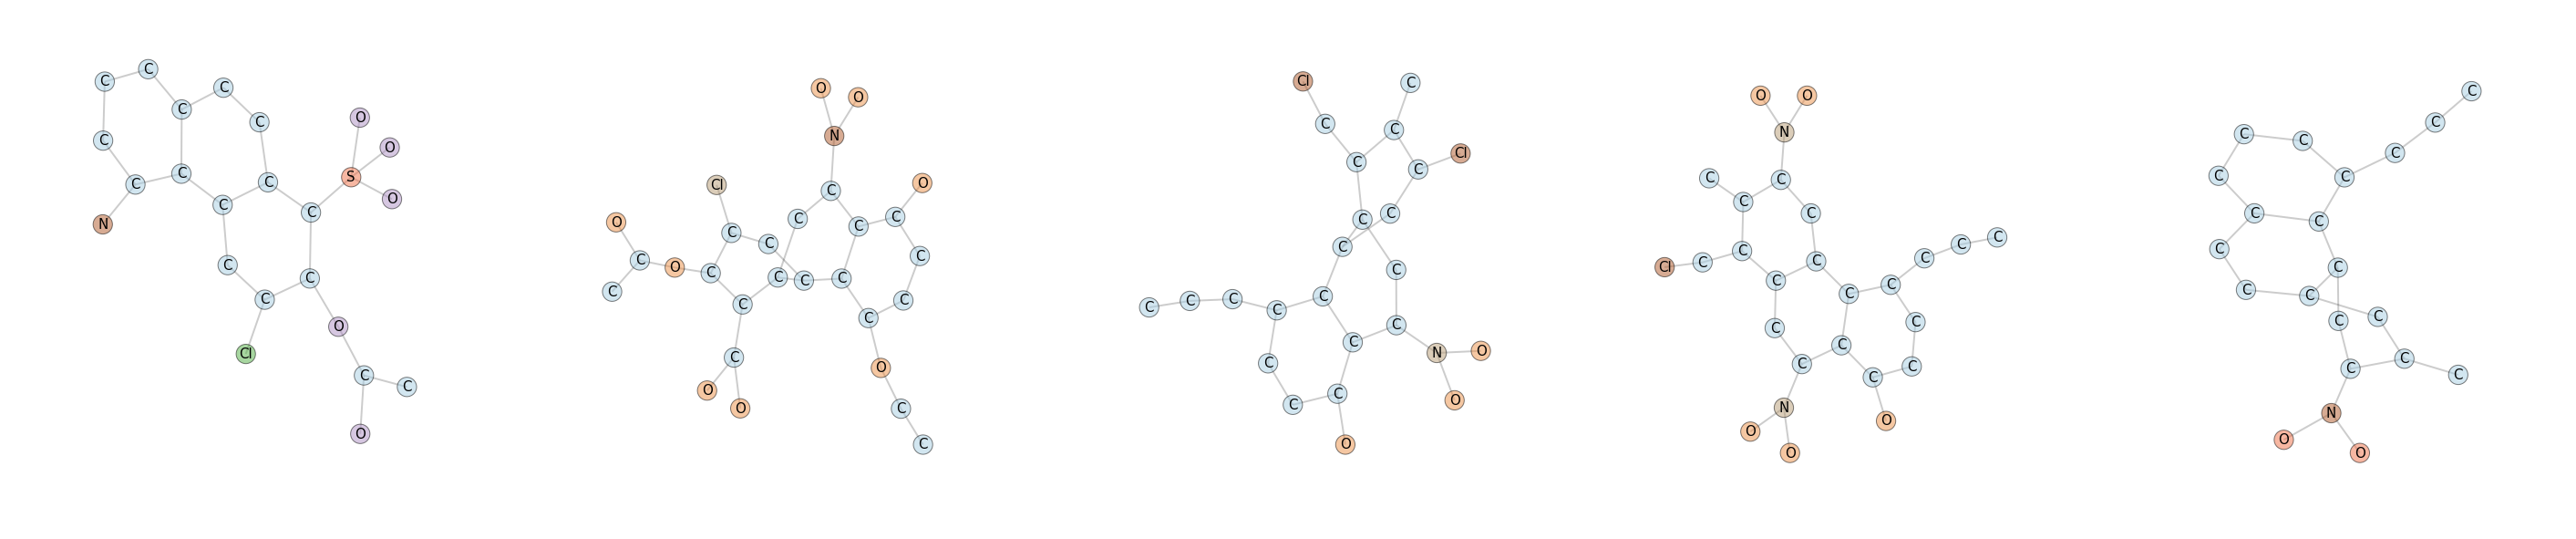

Graph id: 45


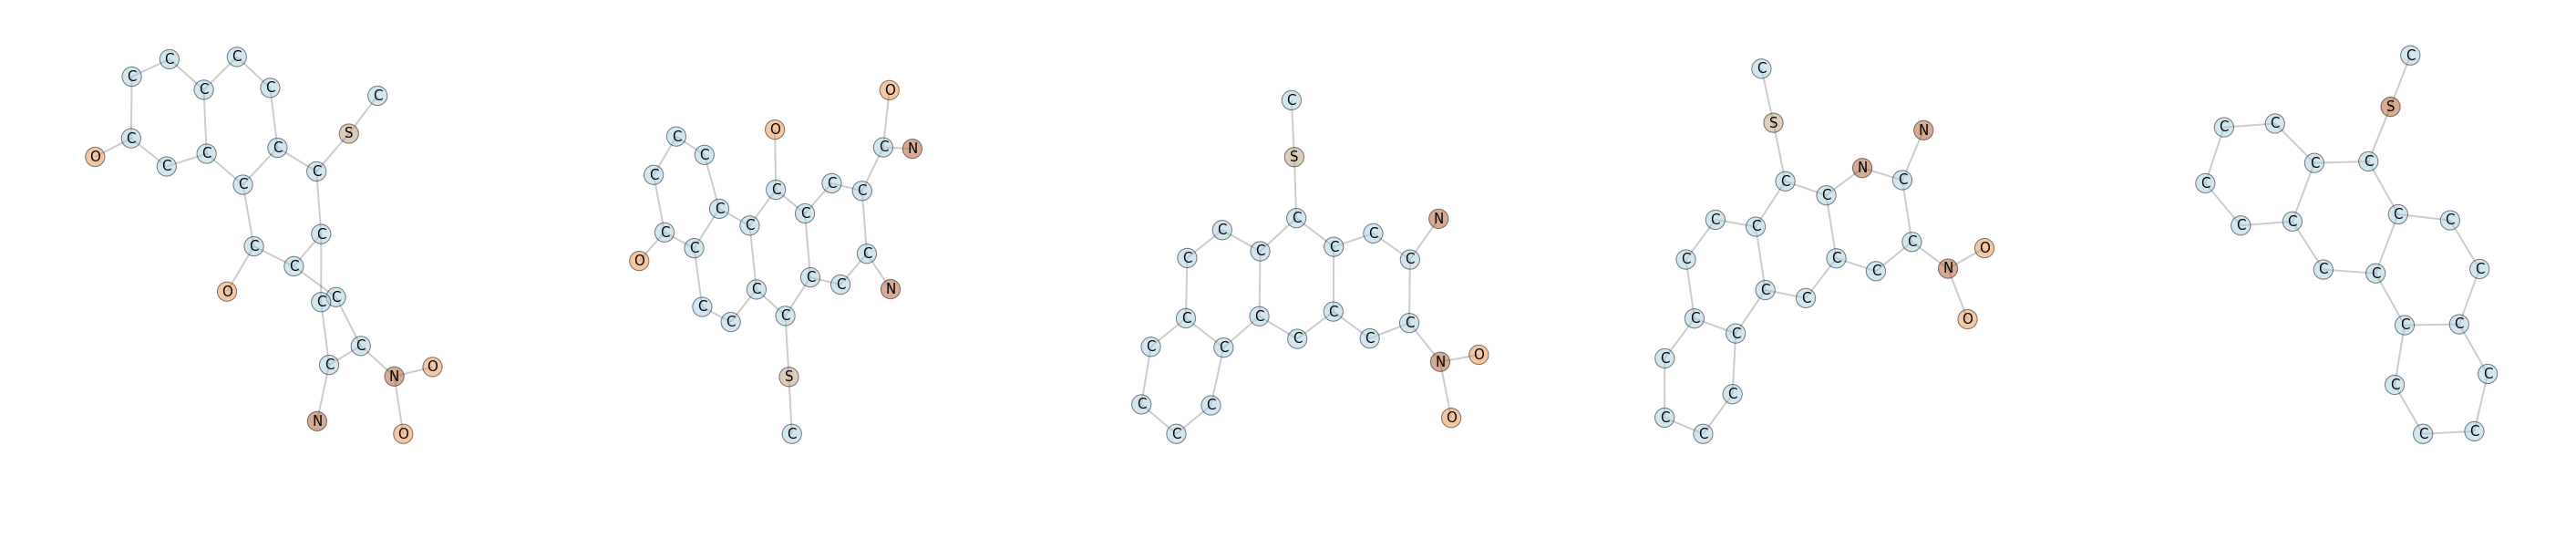

CPU times: user 38.6 s, sys: 2.59 s, total: 41.2 s
Wall time: 55.8 s


In [5]:
%%time
# plot examples of sampling paths
from graphlearn.utils import draw
scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    draw.graphlearn(graphlist,
                   n_graphs_per_line=6, size=10, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=450)

In [6]:
# we sampled with monitoring mode enabled, 
#this is why we could now look at what exactly happened during sampling
#this is step 9 of the 1st graph
sampler.monitors[1][9] 

{'accepted:': [True],
 'debug': ['debuglevel:5 accept_orig_cip: True True',
  'debuglevel:10 _propose_graph: iteration 8 ; core 0 of 5 ; original_cips tried  0 ; size 53'],
 'graphwrapper': <graphlearn.graph.Wrapper at 0x10b707dd0>,
 'id': 9,
 'score': [0.49306290701164546],
 'substitution': ['root: 0 , newcip: 986171 / 516409']}

# Show sample score history

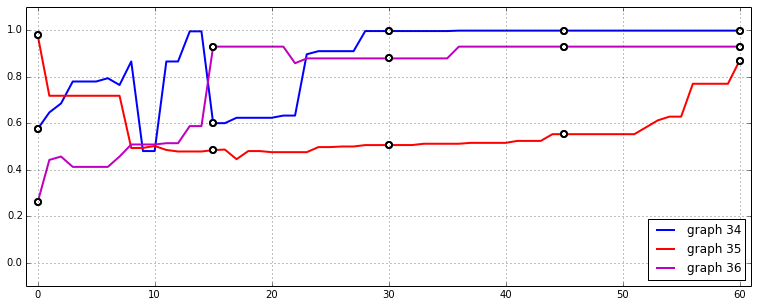

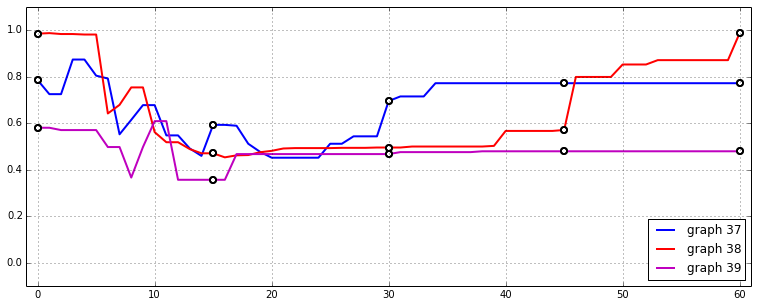

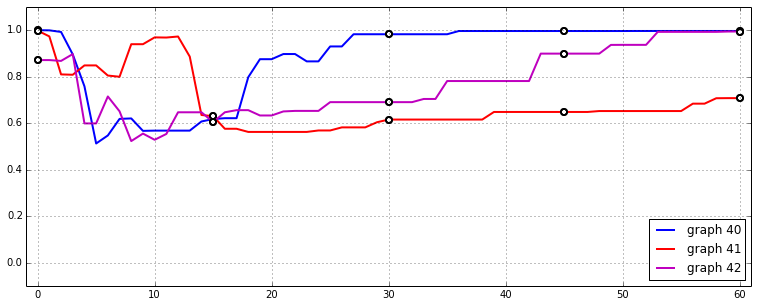

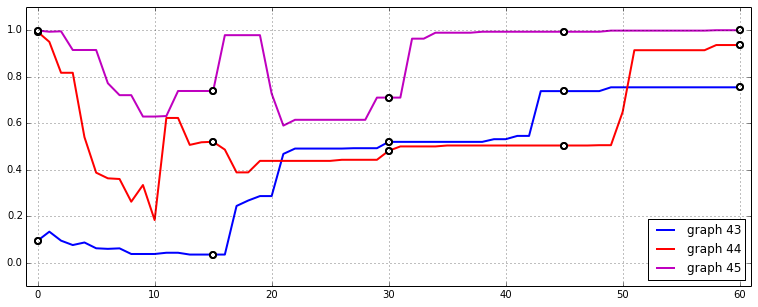

CPU times: user 1.22 s, sys: 9.22 ms, total: 1.23 s
Wall time: 1.23 s


In [8]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
markevery=n_steps/(n_samples)
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):

    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

---